In [1]:
import matplotlib.pyplot
import numpy.random
import torch.utils.data
import torchvision
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Tutorial 1a. Logistic Regression

In the first tutorial, we are going to train a logistic regressor on the MNIST dataset of handwritten digits. Next, we will turn this logistic regressor into a non-linear convolutional network.

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

## Loading Datasets

The following code will load the MNIST dataset. Run it and inspect some of the images and their labels to confirm they are correct.

In [3]:
train_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=True,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=False,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=False,
)

(-0.5, 27.5, 27.5, -0.5)

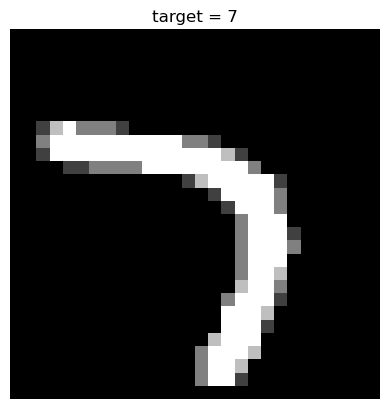

In [4]:
image, target = [*test_dataloader][0]

random_index = numpy.random.randint(0, 64)

image, target = image[random_index, 0], target[random_index]

matplotlib.pyplot.imshow(
    image, 
    cmap="gray", 
    interpolation="nearest",
)

matplotlib.pyplot.title(f"target = {target}")
matplotlib.pyplot.axis("off")

Next, we create a PyTorch dataloader for the MNIST dataset.

Next, implement a logistic regression model in PyTorch. Note that a logistic regressor uses a linear transformation of the input.


## Exercise 1. Logistic Regression Module

In [5]:
class LogisticRegression(Module):
    def __init__(self, input_size: int, num_classes: int):
        super(LogisticRegression, self).__init__()

        ###########################################################################
        # TODO: Instantiate the layer here.                                       #
        ###########################################################################
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        ###########################################################################
        # TODO: Apply the layer to the input.                                     #
        ###########################################################################
        output = self.linear(x)
        return output

In [6]:
module = LogisticRegression(28 * 28, 10)

module = module.to(device=DEVICE)

In [7]:
###########################################################################
# TODO: Create criterion and optimizer here.                              #
###########################################################################
lr = 0.01
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(module.parameters(), lr=lr)

## Training

We will use the following generic training loop for a PyTorch model.

In [8]:
# Train the model. If everything is correct, the loss should go below 0.45.

EPOCHS = 5

# Exponential moving average of the loss:
ema = None

for epoch in range(EPOCHS):
    for batch_index, (train_images, train_targets) in enumerate(train_dataloader):
        train_images = train_images.view(-1, 28 * 28).requires_grad_().to(device=DEVICE)

        train_targets = train_targets.to(device=DEVICE)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = module(train_images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_targets)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updates parameters:
        optimizer.step()

        # NOTE: It is important to call .item() on the loss before summing.
        if ema is None:
            ema = loss.item()
        else:
            ema += (loss.item() - ema) * 0.01

        if batch_index % 500 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_index * len(train_images),
                    len(train_dataloader.dataset),
                    100.0 * batch_index / len(train_dataloader),
                    ema,
                ),
            )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316391
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.921832
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.653403
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.547542
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.512433
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.481366
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.440572
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.427893
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.435489
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.411101


**Question:** For the model you are currently using, is there any difference between using the model in `train` mode or using it in `eval` mode? 

Create an SGD optimizer and us it to train the logistic regressor on the MNIST training data for a few epochs. What loss function do you need to use?

#### Response

Yes, there is a difference between using the model in train mode or using it in eval mode. In fact, during training, we train the model by finding the best paramaters which minimize the loss function, whereas in the eval mode,
we don't modify the model, and use it as is to see how well our model generalize on unseen data.


We will use the CrossEntropyLoss because we have more than 2 classes

### Embeddings 

Visualize the weights of the trained model. What do you see? Why?

In [9]:
# Extract the weights of the model
weights = module.state_dict()

In [10]:
weights

OrderedDict([('linear.weight',
              tensor([[-0.0056,  0.0204, -0.0348,  ..., -0.0003, -0.0309, -0.0060],
                      [ 0.0214,  0.0011, -0.0187,  ..., -0.0121, -0.0009, -0.0006],
                      [ 0.0342, -0.0014,  0.0272,  ..., -0.0050, -0.0183, -0.0056],
                      ...,
                      [-0.0198,  0.0158, -0.0204,  ..., -0.0306,  0.0068,  0.0030],
                      [-0.0121,  0.0105, -0.0145,  ...,  0.0323, -0.0318,  0.0262],
                      [ 0.0166, -0.0202, -0.0316,  ..., -0.0167, -0.0256, -0.0009]])),
             ('linear.bias',
              tensor([-0.1036,  0.1658, -0.0193, -0.1091,  0.0849,  0.2643, -0.0082,  0.1274,
                      -0.3193, -0.0276]))])

In [11]:
assert weights['linear.weight'].shape == (10, 28 * 28)

(-0.5, 151.5, 61.5, -0.5)

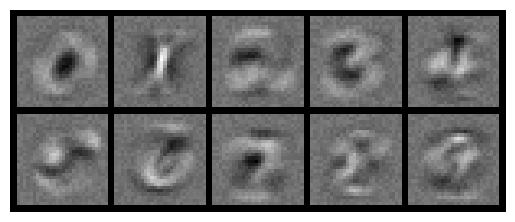

In [12]:
matplotlib.pyplot.imshow(
    numpy.transpose(
        torchvision.utils.make_grid(
            weights['linear.weight'].view(10, 1, 28, 28),
            normalize=True,
            nrow=5,
        ), 
        (1, 2, 0),
    ), 
    interpolation="nearest",
)

matplotlib.pyplot.grid(False)
matplotlib.pyplot.gca().axis("off")

#### Response

The weights of the trained model show us the classes of weights which produces values from 0-9

## Evaluation

Use the following function to measure the test accuracy of your trained model.

In [13]:
correct_predictions = 0
predictions = 0

# Iterate through test dataset
for test_images, test_targets in test_dataloader:
    test_images = test_images.view(-1, 28 * 28).to(DEVICE)

    # Forward pass only to get logits/output
    outputs = module(test_images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    predictions += test_targets.size(0)

    if torch.cuda.is_available():
        correct_predictions += (predicted.cpu() == test_targets.cpu()).sum()
    else:
        correct_predictions += (predicted == test_targets).sum()

correct_predictions.item() / predictions

0.9